# Imports

In [1]:
import os
import csv
import json
import gzip
import pickle
import pathlib
import datetime
import operator
import itertools
import unicodedata
import collections

In [2]:
import nltk
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Constants

In [3]:
PROJECT_DIR = pathlib.Path('~/project').expanduser()
DATA_DIR = PROJECT_DIR / 'data'
CORPUS_ROOT = DATA_DIR / 'sample'

# PickledCorpusReader

In [4]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

In [5]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids
    
    def feeds(self):
        data = self.open('feeds.json')
        return json.load(data)

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def tagged_paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for tagged_para in doc:
                yield tagged_para
    
    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of tokens.
        """
        for tagged_para in self.tagged_paras(fileids, categories):
            yield [[word for word, tag in tagged_sent]
                   for tagged_sent in tagged_para]

    def tagged_sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for tagged_para in self.tagged_paras(fileids, categories):
            for tagged_sent in tagged_para:
                yield tagged_sent
                
    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        tokens.
        """
        for tagged_sent in self.tagged_sents(fileids, categories):
            yield [word for word, tag in tagged_sent]
    
    def tagged_words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for sent in self.tagged_sents(fileids, categories):
            for token, tag in sent:
                yield token, tag

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of tokens.
        """
        for word, tag in self.tagged_words(fileids, categories):
            yield word
    
    def describe(self, fileids=None, categories=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time.time()
        
        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Perform single pass over paragraphs, tokenize and count
        for para in self.paras(fileids, categories):
            counts['paras'] += 1
            
            for sent in para:
                counts['sents'] += 1
                
                for word, tag in sent:
                    counts['words'] += 1
                    tokens[word] += 1
        
        # Compute the number of files and categories in the corpus
        n_fileids = len(self._resolve(fileids, categories) or self.fileids())
        n_topics  = len(self.categories(self._resolve(fileids, categories)))

        # Return data structure with information
        return {
            'files':  n_fileids,
            'topics': n_topics,
            'paras':  counts['paras'],
            'sents':  counts['sents'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': counts['words'] / len(tokens),
            'ppdoc':  counts['paras'] / n_fileids,
            'sppar':  counts['sents'] / counts['paras'],
            'secs':   time.time() - started,
        }

In [6]:
corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
words = collections.Counter(corpus.words())

print(f"{len(words.keys()):,} vocabulary {sum(words.values()):,} word count")

58,748 vocabulary 1,624,862 word count


# TextNormalizer

In [7]:
from nltk.corpus import wordnet as wn

class TextNormalizer(object):

    def __init__(self, language='english'):
        self.stopwords  = frozenset(nltk.corpus.stopwords.words(language))
        self.lemmatizer = nltk.WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P')
            for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]

# Visualizing Feature Space

## Visual Feature Analysis

### n-gram viewer

In [8]:
PUBDATES_PATH = DATA_DIR / 'pubdates.csv.gz' # mapping of docid to pubdate
WORDSERIES_PATH = pathlib.Path('wordseries.json') # word:date count
DATE_FORMAT = "%Y-%m-%d"

In [9]:
def docid(fileid):
    """
    Returns the docid parsed from the file id
    """
    fname = os.path.basename(fileid)
    return os.path.splitext(fname)[0]

In [10]:
def parse_date(ts):
    """
    Helper function to handle weird mongo datetime output.
    """
    return datetime.datetime.strptime(ts.split()[0], DATE_FORMAT)

In [11]:
def load_pubdates(fileids, path=PUBDATES_PATH):
    fileids = frozenset(map(docid, fileids))

    with gzip.open(path, 'rt') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        return {
            fileid: parse_date(raw_date)
            for fileid, raw_date in reader
            if fileid in fileids and raw_date
        }

In [12]:
class WordSeries(object):

    @classmethod
    def load(cls, path):
        """
        Load the word series from disk.
        """
        obj = cls()
        with path.open() as f:
            for line in f:
                data = json.loads(line.strip())
                word = data['word']
                for raw_date, count in data['series'].items():
                    date = datetime.datetime.strptime(raw_date, DATE_FORMAT)
                    obj.words[word][date] = count
        return obj

    def __init__(self):
        # a map of token -> date -> count
        self.words = collections.defaultdict(
            collections.Counter
        )

    def __len__(self):
        return len(self.words)

    def __getitem__(self, key):
        if key not in self.words:
            raise KeyError(f'{key!r} not in word list')
        
        dates, counts = zip(*sorted(self.words[key].items(),
                                    key=operator.itemgetter(0)))

        # Return a timeseries for the specified key
        return pd.Series(counts, index=dates, name=key)

    def read(self, corpus, pubdates_path=PUBDATES_PATH):
        """
        Creates a time series for each unique word in the corpus, normalizing
        the words and filtering out stopwords, etc.
        """
        normalize = TextNormalizer().normalize
        pubdates = load_pubdates(corpus.fileids(), pubdates_path)

        # count all tokens over time
        for fileid, doc in zip(corpus.fileids(), corpus.docs()):
            fileid = docid(fileid)
            pubdate = pubdates.get(fileid, None)
            if not pubdate:
                continue

            # self.words hold token to date to count
            for token in normalize(doc):
                self.words[token][pubdate] += 1

    def dump(self, path=WORDSERIES_PATH):
        """
        Dump the word series to disk an easily parseable manner (jsonl).
        """
        with path.open('w') as f:
            for word, counter in self.words.items():
                obj = {'word': word,
                       'series': {date.strftime(DATE_FORMAT): count
                                  for date, count in counter.items()}}
                f.write(json.dumps(obj))
                f.write('\n')

    def plot(self, terms, figsize, xlim):
        """
        Plot the word series for each term in the terms list
        """
        data = (
            pd.DataFrame({term: self[term]
                          for term in terms})
            .resample('D')
            .sum()
        )
        return data.plot(
            title='Token Frequency over Time',
            xlabel='publication date',
            ylabel='word count',
            xlim=xlim,
            figsize=figsize,
            legend=True
        )

In [13]:
corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())

if not WORDSERIES_PATH.exists():
    # Build the word series and dump it to disk.
    series = WordSeries()
    series.read(corpus)
    series.dump()
    print(f'wrote {len(series)} word series to {WORDSERIES_PATH}')
else:
    series = WordSeries.load(WORDSERIES_PATH)

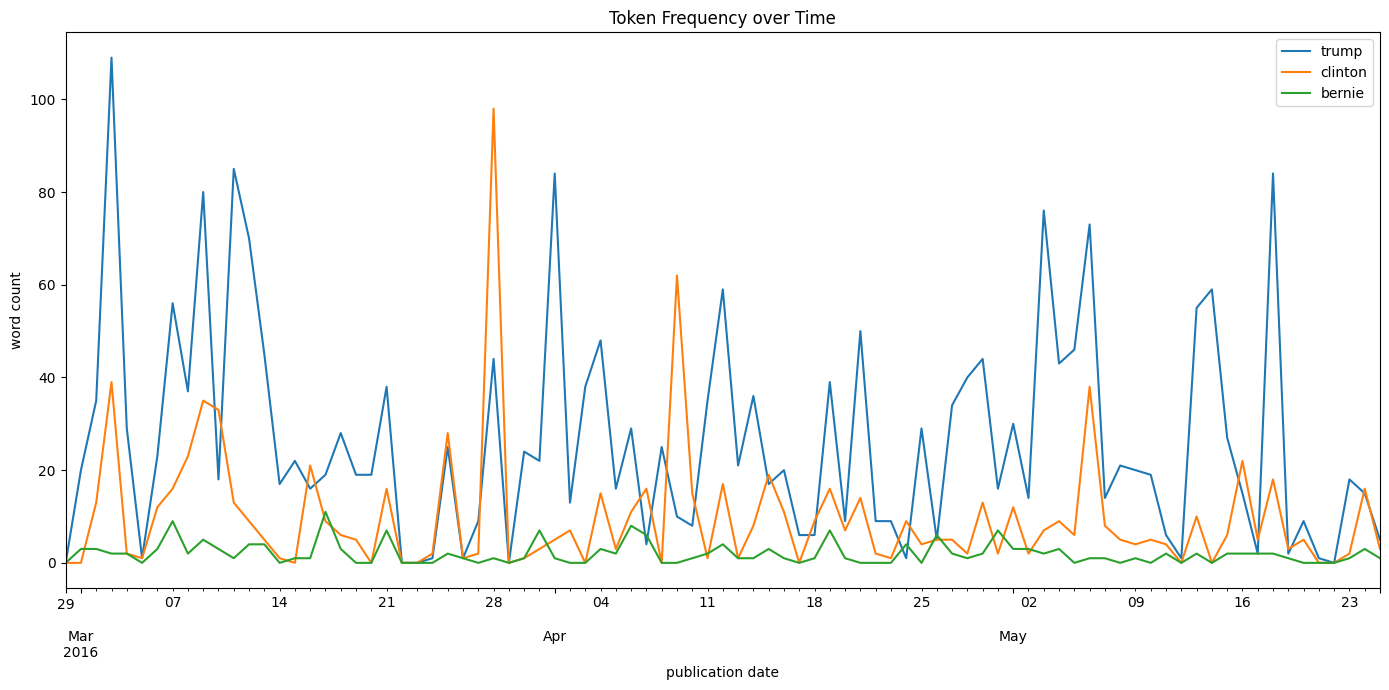

In [14]:
series.plot(
    terms=['trump', 'clinton', 'bernie'],
    figsize=(14, 7),
    xlim=('2016-02-29','2016-05-25')
)
plt.tight_layout()
plt.show()

### Network visualization

In [15]:
OZ_PATH = DATA_DIR / 'oz.json'

In [16]:
def cooccurrence(chapters, cast):
    return collections.Counter(
        (x, y)
        for title, chapter in chapters.items()
        for sent in nltk.sent_tokenize(chapter)
        for x, y in itertools.combinations(cast, 2)
        if x in sent and y in sent
    )

In [17]:
with OZ_PATH.open(encoding='utf-8-sig') as f:
    oz_data = json.load(f)

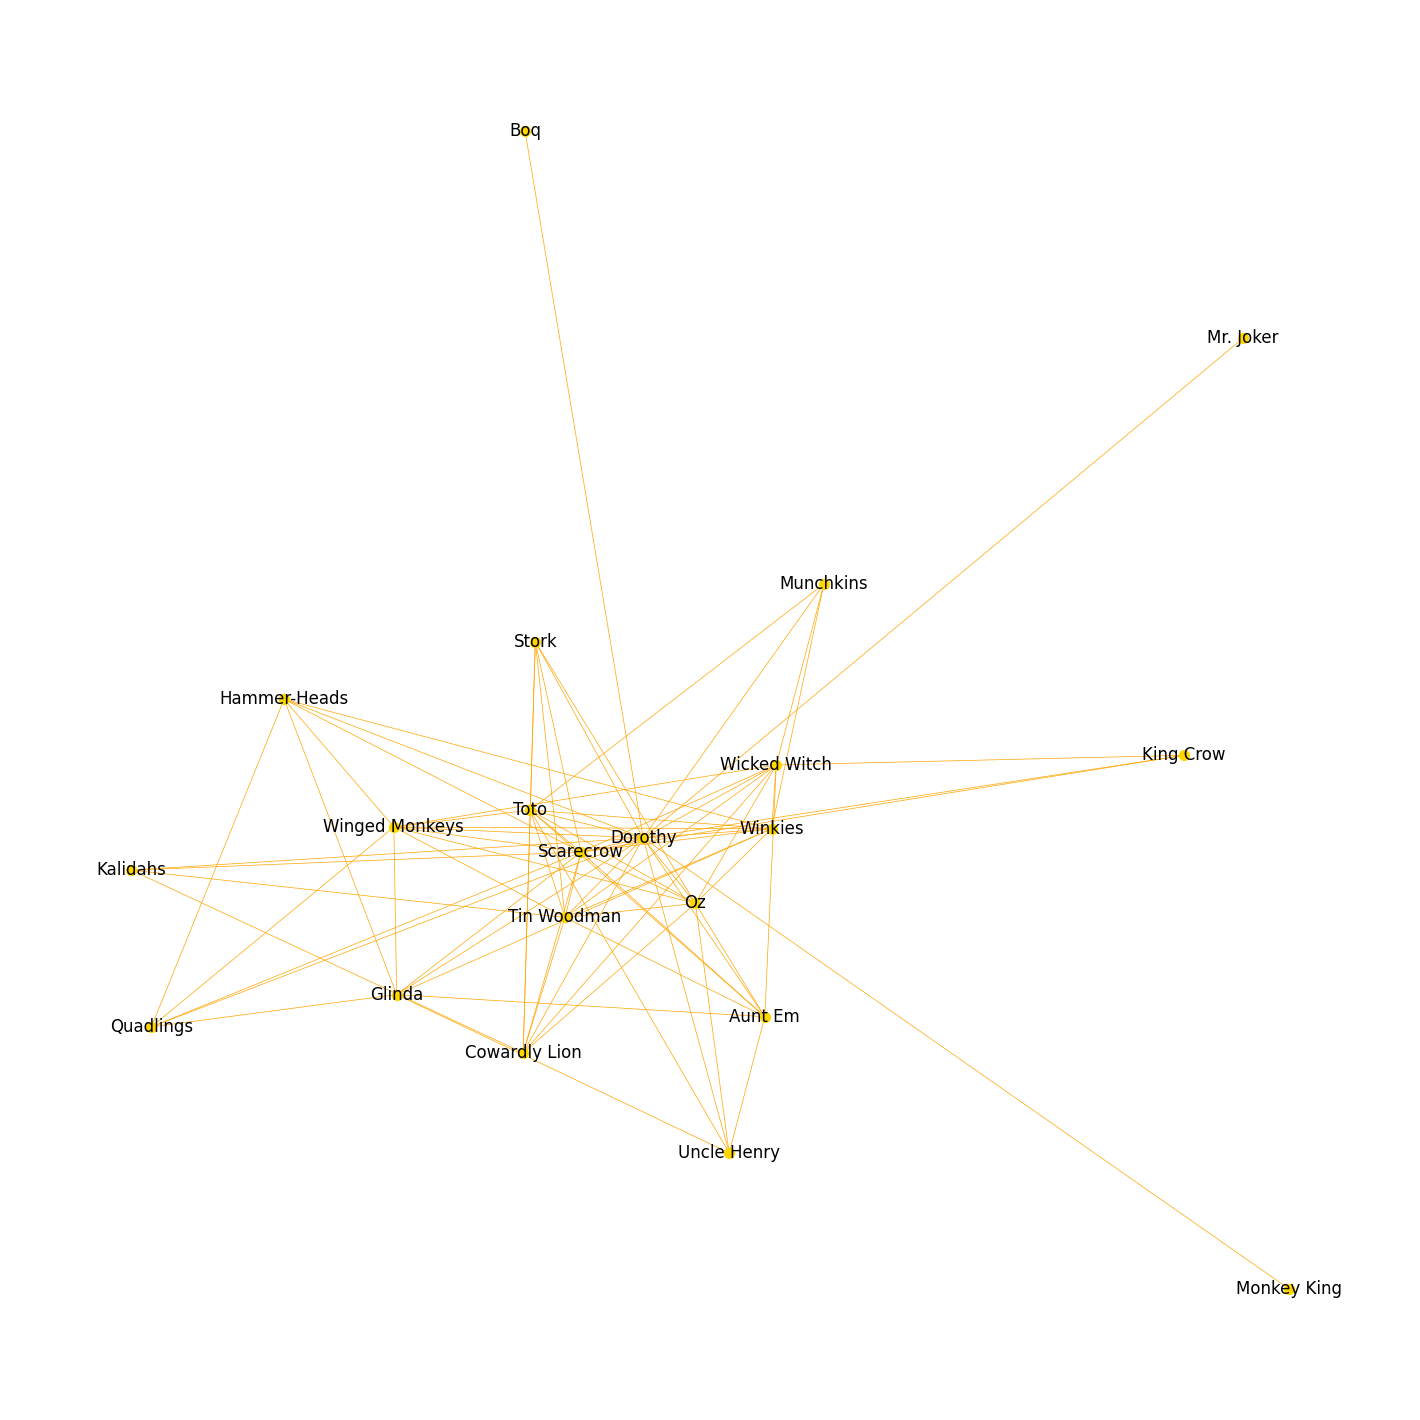

In [18]:
G = nx.Graph()
G.name = 'The Social Network of Oz'
pairs = cooccurrence(oz_data['chapters'], oz_data['cast'])
for (x, y), weight in pairs.items():
    G.add_edge(x, y, weight=weight)

# Make Dorothy the center
D = nx.ego_graph(G, 'Dorothy')
edges, weights = zip(*nx.get_edge_attributes(D, 'weight').items())

# Push nodes away that are less related to Dorothy
pos = nx.spring_layout(D, k=.5, iterations=40)

plt.figure(figsize=(14, 14))
nx.draw(D, pos, node_color='gold', node_size=50, edgelist=edges,
        width=.5, edge_color='orange', with_labels=True, font_size=12)
plt.show()

### Co-occurrence plots

In [19]:
def matrix(chapters, cast):
    combos = collections.Counter(
        (x, y)
        for title, chapter in chapters.items()
        for sent in nltk.sent_tokenize(chapter)
        for x, y in itertools.combinations_with_replacement(cast, 2)
        if x in sent and y in sent
    )
    return [[max(combos[x, y], combos[y, x]) for y in cast]
            for x in cast]

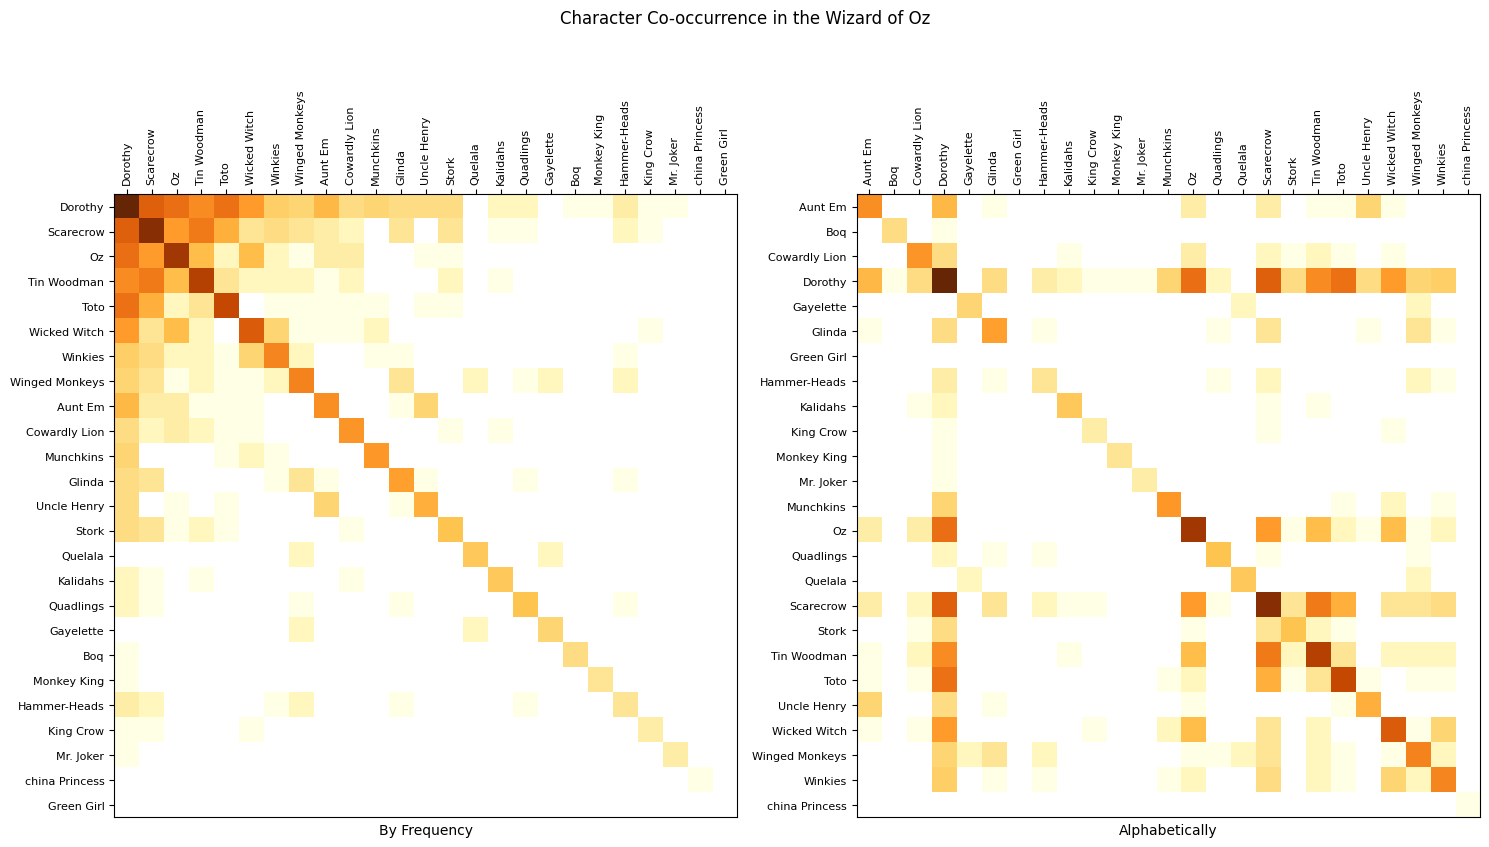

In [20]:
from matplotlib.colors import LogNorm

# First make the matrices
# By frequency
mtx = matrix(oz_data['chapters'], oz_data['cast'])
# And alphabetically
alpha_cast = sorted(oz_data['cast'])
alpha_mtx = matrix(oz_data['chapters'], alpha_cast)

# Now create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Character Co-occurrence in the Wizard of Oz', fontsize=12)

n = len(oz_data['cast'])
x_tick_marks = np.arange(n)
y_tick_marks = np.arange(n)

ax1.set_xticks(x_tick_marks)
ax1.set_yticks(y_tick_marks)
ax1.set_xticklabels(oz_data['cast'], fontsize=8, rotation=90)
ax1.set_yticklabels(oz_data['cast'], fontsize=8)
ax1.xaxis.tick_top()
ax1.set_xlabel('By Frequency')
ax1.imshow(mtx, norm=LogNorm(), interpolation='nearest', cmap='YlOrBr')

ax2.set_xticks(x_tick_marks)
ax2.set_yticks(y_tick_marks)
ax2.set_xticklabels(alpha_cast, fontsize=8, rotation=90)
ax2.set_yticklabels(alpha_cast, fontsize=8)
ax2.xaxis.tick_top()
ax2.set_xlabel('Alphabetically')
ax2.imshow(alpha_mtx, norm=LogNorm(), interpolation='nearest', cmap='YlOrBr')

plt.tight_layout()
plt.show()

### Text x-rays and dispersion plots

In [21]:
def get_data(chapters):
    words = []
    titles = []
    chapter_lengths = []
    for title, chapter in chapters.items():
        # Collect the chapter titles
        titles.append(title)
        for sent in nltk.sent_tokenize(chapter):
            for word in nltk.word_tokenize(sent):
                # Collect all of the words
                words.append(word)
        # Record the words length at each chapter
        chapter_lengths.append(len(words))
    return words, titles, [0] + chapter_lengths[:-1]

In [22]:
def get_points(words, cast):
    return [
        # Add a point for each time a character appears
        (i, j)
        for i, word in enumerate(words)
        for j, character in enumerate(cast)
        # Some characters have 1-word names
        if character == word
        # Some characters have 2-word names
        or character == ' '.join((words[i - 1], word))
    ]

In [23]:
def dispersion_plot(points, cast, titles, chapter_starts, figsize=(15, 5)):
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    # Add vertical lines for each chapter start
    for start in chapter_starts:
        plt.axvline(start, linestyle='-', color='gainsboro')
    # Plot the character mentions
    plt.plot(*list(zip(*points)), '|', color='darkorange', scalex=.1)
    plt.xticks(chapter_starts, titles, size=6, rotation=90)
    plt.yticks(list(range(len(cast))), cast, size=8)
    plt.ylim(-1, len(cast))
    plt.title('Character Mentions in the Wizard of Oz')
    plt.show()

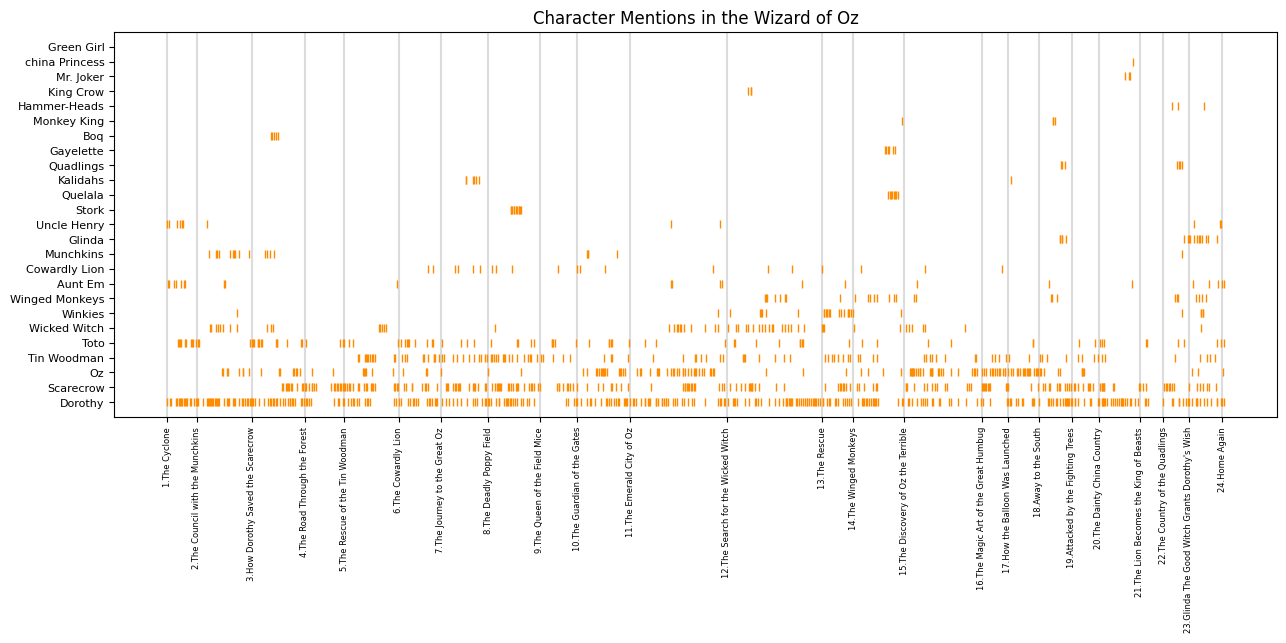

In [24]:
oz_words, titles, chapter_starts = get_data(oz_data['chapters'])
points = get_points(oz_words, oz_data['cast'])
dispersion_plot(points, oz_data['cast'], titles, chapter_starts)

## Guided Feature Engineering

### Part-of-speech tagging

In [25]:
from yellowbrick.text.postag import PosTagVisualizer

In [26]:
from yellowbrick.text.base import TextVisualizer

class LegacyPosTagVisualizer(TextVisualizer):
    
    def __init__(self, ax=None, **kwargs):
        super().__init__(ax=ax, **kwargs)
        self.COLORS = {
            'white'      : "\033[0;37m{}\033[0m",
            'yellow'     : "\033[0;33m{}\033[0m",
            'green'      : "\033[0;32m{}\033[0m",
            'blue'       : "\033[0;34m{}\033[0m",
            'cyan'       : "\033[0;36m{}\033[0m",
            'red'        : "\033[0;31m{}\033[0m",
            'magenta'    : "\033[0;35m{}\033[0m",
            'black'      : "\033[0;30m{}\033[0m",
            'darkwhite'  : "\033[1;37m{}\033[0m",
            'darkyellow' : "\033[1;33m{}\033[0m",
            'darkgreen'  : "\033[1;32m{}\033[0m",
            'darkblue'   : "\033[1;34m{}\033[0m",
            'darkcyan'   : "\033[1;36m{}\033[0m",
            'darkred'    : "\033[1;31m{}\033[0m",
            'darkmagenta': "\033[1;35m{}\033[0m",
            'darkblack'  : "\033[1;30m{}\033[0m",
             None        : "\033[0;0m{}\033[0m"
        }
        self.TAGS = {
            'NN'  : 'green',
            'NNS' : 'green',
            'NNP' : 'green',
            'NNPS': 'green',
            'VB'  : 'blue',
            'VBD' : 'blue',
            'VBG' : 'blue',
            'VBN' : 'blue',
            'VBP' : 'blue',
            'VBZ' : 'blue',
            'JJ'  : 'red',
            'JJR' : 'red',
            'JJS' : 'red',
            'RB'  : 'cyan',
            'RBR' : 'cyan',
            'RBS' : 'cyan',
            'IN'  : 'darkwhite',
            'POS' : 'darkyellow',
            'PRP$': 'magenta',
            'PRP$': 'magenta',
            'DT'  : 'black',
            'CC'  : 'black',
            'CD'  : 'black',
            'WDT' : 'black',
            'WP'  : 'black',
            'WP$' : 'black',
            'WRB' : 'black',
            'EX'  : 'yellow',
            'FW'  : 'yellow',
            'LS'  : 'yellow',
            'MD'  : 'yellow',
            'PDT' : 'yellow',
            'RP'  : 'yellow',
            'SYM' : 'yellow',
            'TO'  : 'yellow',
            'None': 'off'
        }

    def colorize(self, token, color):
        return self.COLORS[color].format(token)

    def transform(self, tagged):
        self.sequence = [
            (token, self.TAGS.get(tag))
            for sent in tagged
            for token, tag in sent
        ]
        print(' '.join(
            (self.colorize(token, color)
             for token, color in self.sequence)
        ))

In [27]:
def process_text(text):
    return [nltk.pos_tag(nltk.word_tokenize(sent))
            for sent in nltk.sent_tokenize(text)]

In [28]:
pie = """
    In a small saucepan, combine sugar and eggs
    until well blended. Cook over low heat, stirring
    constantly, until mixture reaches 160° and coats
    the back of a metal spoon. Remove from the heat.
    Stir in chocolate and vanilla until smooth. Cool
    to lukewarm (90°), stirring occasionally. In a small
    bowl, cream butter until light and fluffy. Add cooled
    chocolate mixture; beat on high speed for 5 minutes
    or until light and fluffy. In another large bowl,
    beat cream until it begins to thicken. Add
    confectioners' sugar; beat until stiff peaks form.
    Fold into chocolate mixture. Pour into crust. Chill
    for at least 6 hours before serving. Garnish with
    whipped cream and chocolate curls if desired.
"""

In [29]:
pie_processed = process_text(pie)

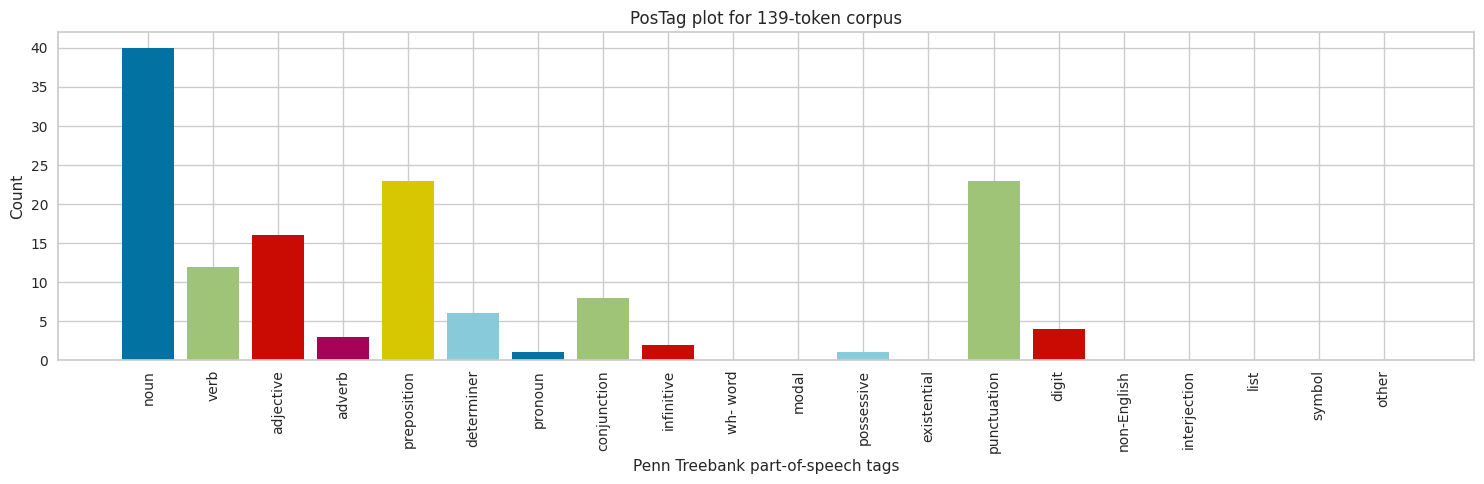

In [30]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 5))
viz = PosTagVisualizer(ax=ax)
viz.fit([pie_processed])
viz.show()
plt.show()

In [31]:
legacy_viz = LegacyPosTagVisualizer()

In [32]:
legacy_viz.transform(pie_processed)

In a small saucepan , combine sugar and eggs until well blended . Cook over low heat , stirring constantly , until mixture reaches 160° and coats the back of a metal spoon . Remove from the heat . Stir in chocolate and vanilla until smooth . Cool to lukewarm ( 90° ) , stirring occasionally . In a small bowl , cream butter until light and fluffy . Add cooled chocolate mixture ; beat on high speed for 5 minutes or until light and fluffy . In another large bowl , beat cream until it begins to thicken . Add confectioners ' sugar ; beat until stiff peaks form . Fold into chocolate mixture . Pour into crust . Chill for at least 6 hours before serving . Garnish with whipped cream and chocolate curls if desired .


In [33]:
nursery_rhyme = """
    Baa, baa, black sheep,
    Have you any wool?
    Yes, sir, yes, sir,
    Three bags full;
    One for the master,
    And one for the dame,
    And one for the little boy
    Who lives down the lane.
"""
nursery_rhyme_processed = process_text(nursery_rhyme)
legacy_viz.transform(nursery_rhyme_processed)

Baa , baa , black sheep , Have you any wool ? Yes , sir , yes , sir , Three bags full ; One for the master , And one for the dame , And one for the little boy Who lives down the lane .


### Most informative features

In [34]:
from yellowbrick.datasets import load_hobbies
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
corpus = load_hobbies(DATA_DIR)

In [36]:
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(corpus.data)
features = vectorizer.get_feature_names_out()

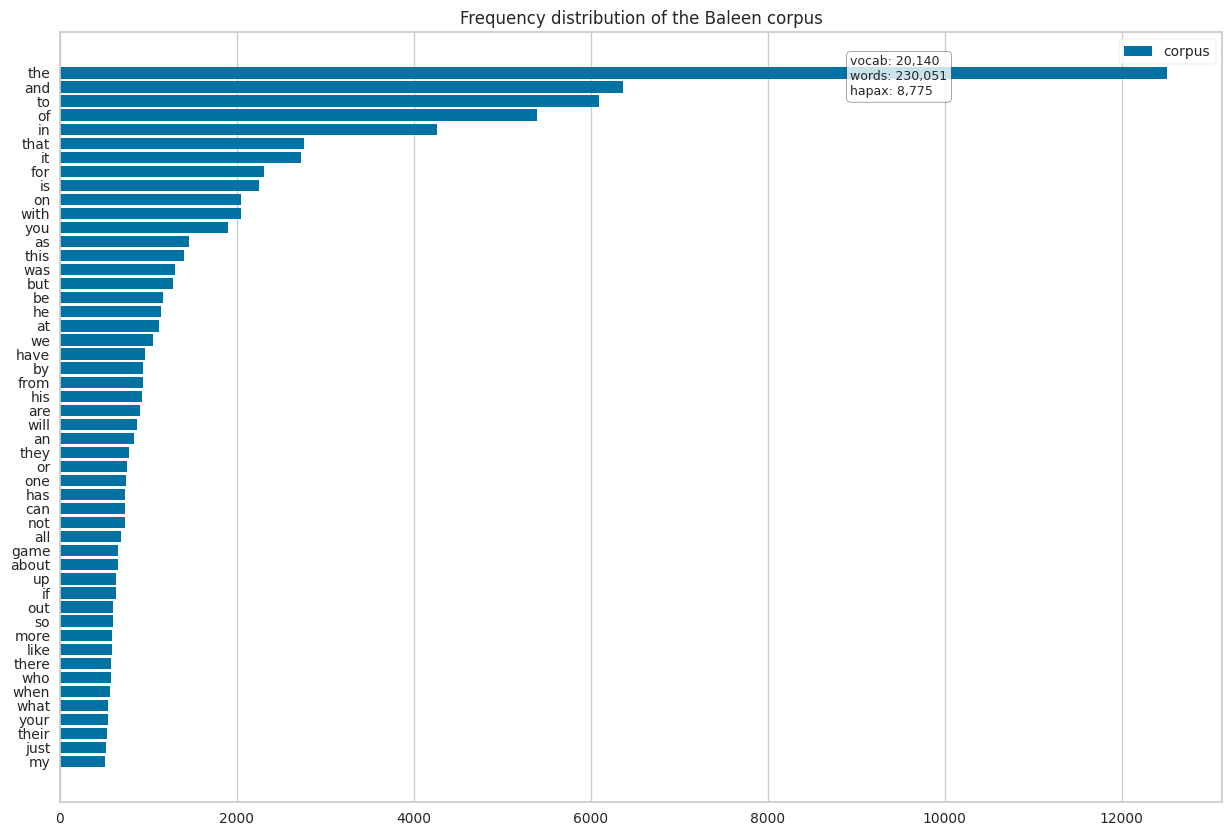

In [37]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 10))
visualizer = FreqDistVisualizer(
    features=features, ax=ax,
    title='Frequency distribution of the Baleen corpus'
)
visualizer.fit(docs)
visualizer.show()
plt.show()

In [38]:
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(corpus.data)
features = vectorizer.get_feature_names_out()

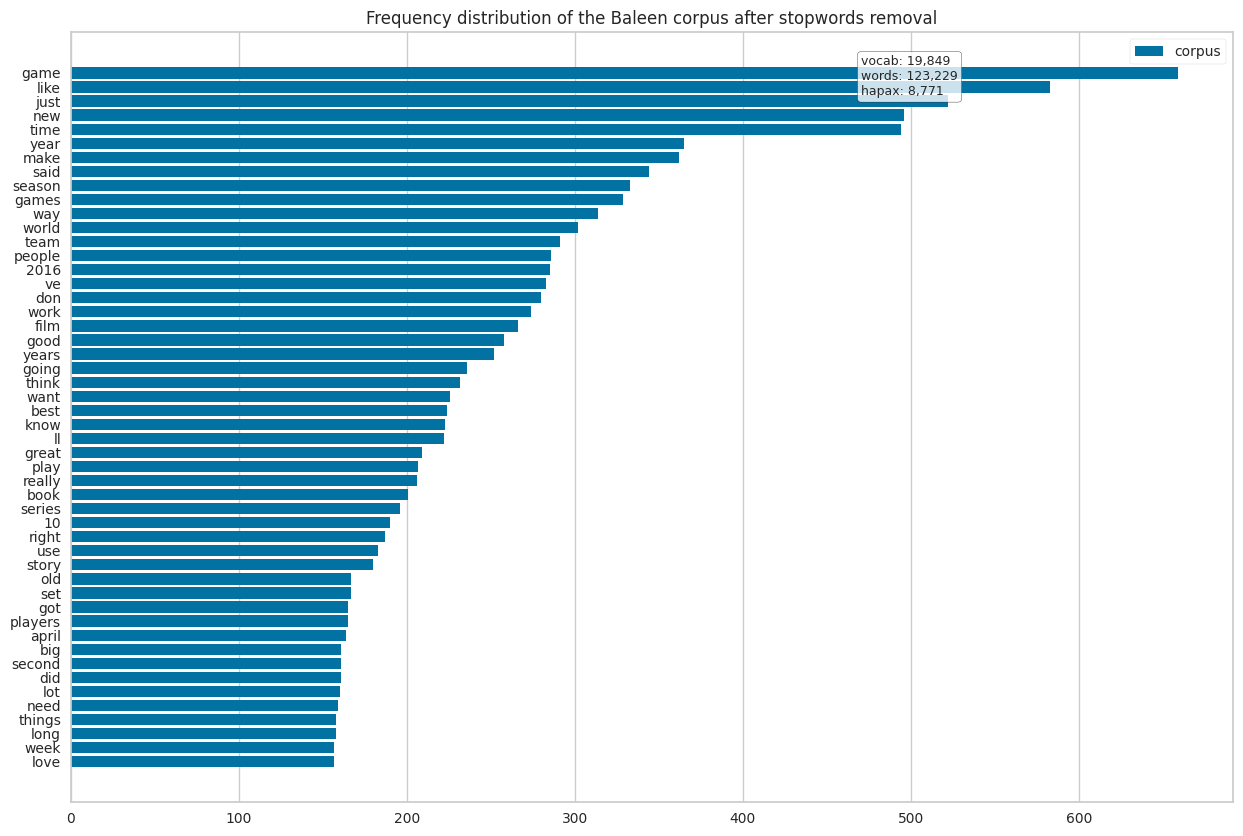

In [39]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 10))
visualizer = FreqDistVisualizer(
    features=features, ax=ax,
    title='Frequency distribution of the Baleen corpus after stopwords removal'
)
visualizer.fit(docs)
visualizer.show()
plt.show()

In [40]:
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(
    text
    for text, target in zip(corpus.data, corpus.target)
    if target == 'cooking'
)
features = vectorizer.get_feature_names_out()

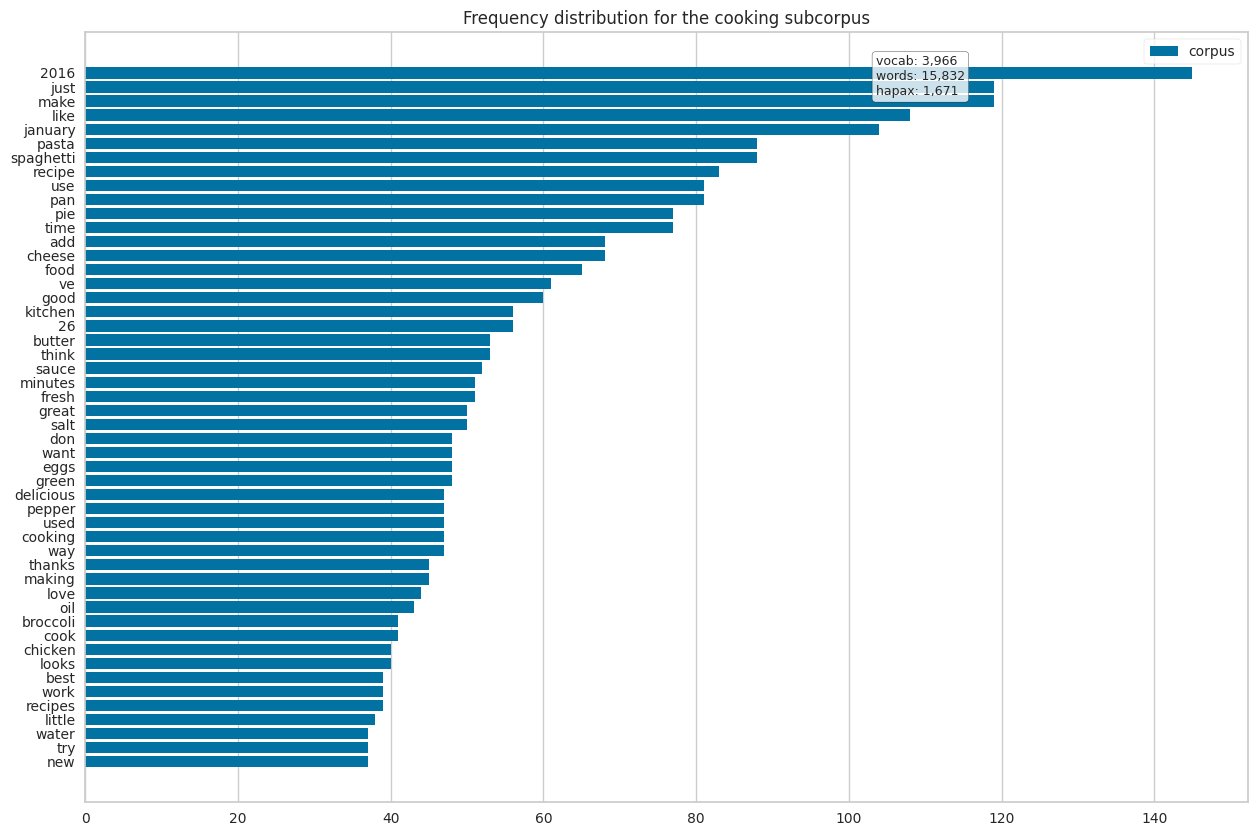

In [41]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 10))
visualizer = FreqDistVisualizer(
    features=features, ax=ax,
    title='Frequency distribution for the cooking subcorpus'
)
visualizer.fit(docs)
visualizer.show()
plt.show()

In [42]:
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(
    text
    for text, target in zip(corpus.data, corpus.target)
    if target == 'gaming'
)
features = vectorizer.get_feature_names_out()

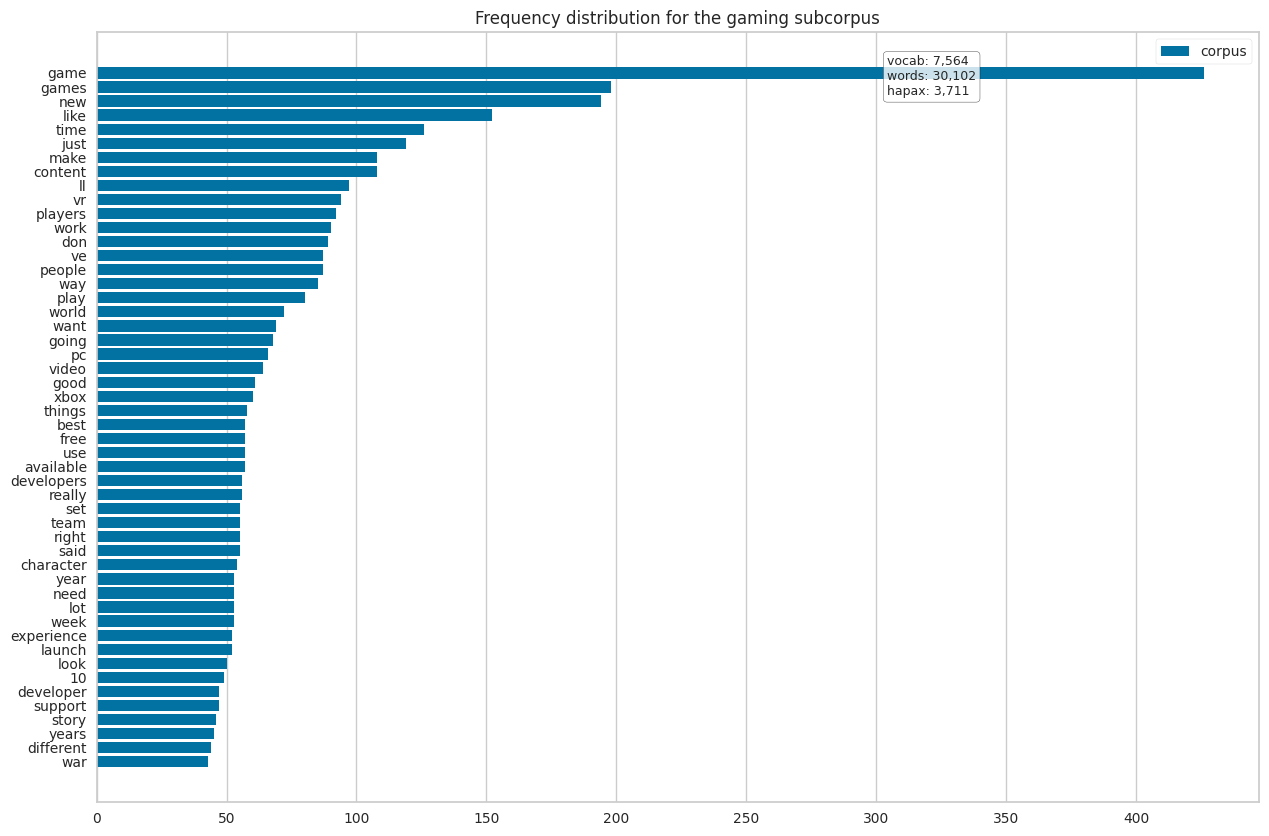

In [43]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 10))
visualizer = FreqDistVisualizer(
    features=features, ax=ax,
    title='Frequency distribution for the gaming subcorpus'
)
visualizer.fit(docs)
visualizer.show()
plt.show()

# Model Diagnostics

## Visualizing Clusters

In [44]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(corpus.data)

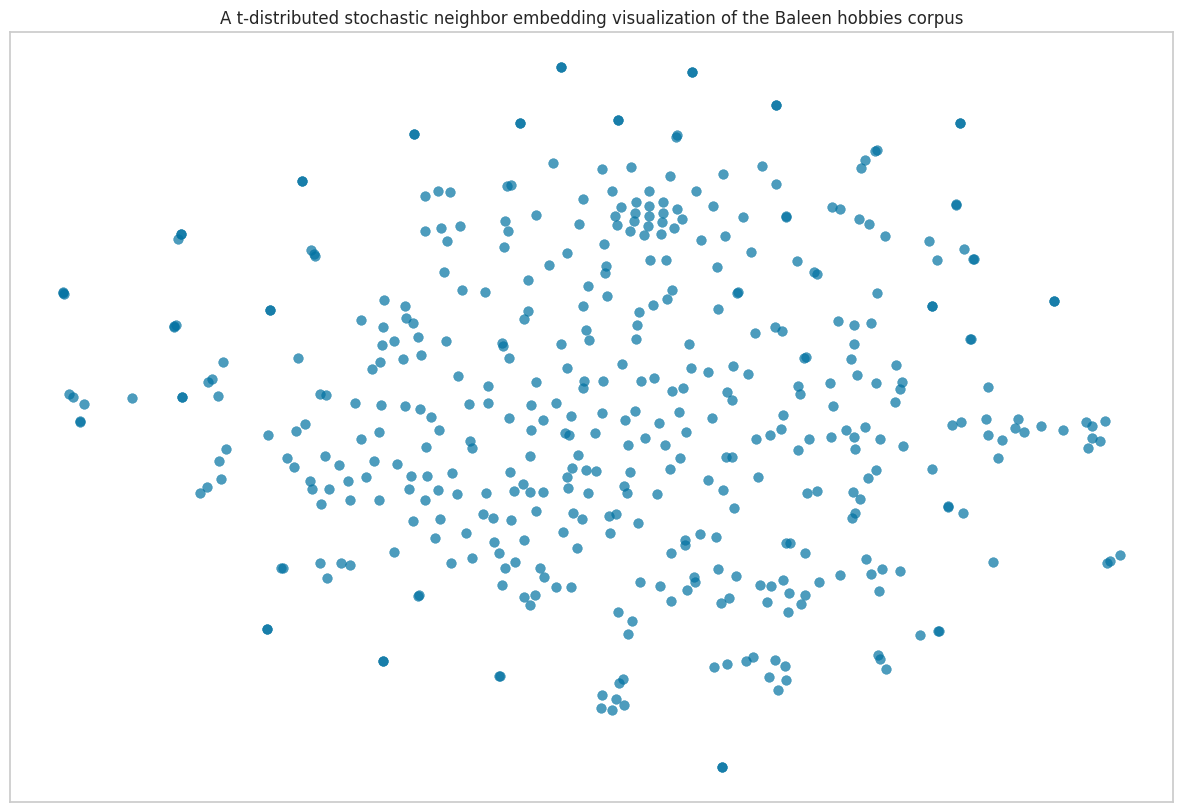

In [46]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 10))
tsne = TSNEVisualizer(
    ax=ax, random_state=42,
    title='A t-distributed stochastic neighbor embedding visualization of the Baleen hobbies corpus'
)
tsne.fit(docs)
tsne.show()
plt.show()

In [47]:
from sklearn.cluster import KMeans

In [48]:
clusters = KMeans(n_clusters=5, n_init='auto', random_state=42)
clusters.fit(docs)

KMeans(n_clusters=5, n_init='auto', random_state=42)

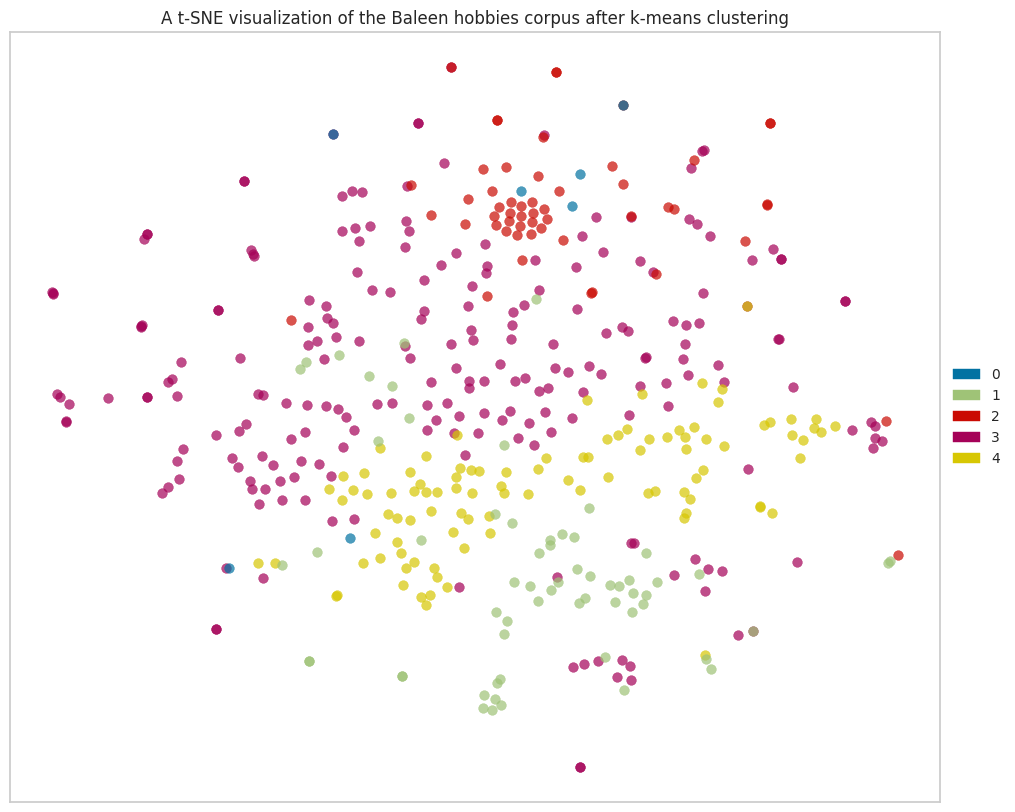

In [49]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 10))
tsne = TSNEVisualizer(
    ax=ax, random_state=42,
    title='A t-SNE visualization of the Baleen hobbies corpus after k-means clustering'
)
tsne.fit(docs, clusters.labels_)
tsne.show()
plt.show()

## Visualizing Classes

In [50]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(corpus.data)
labels = corpus.target

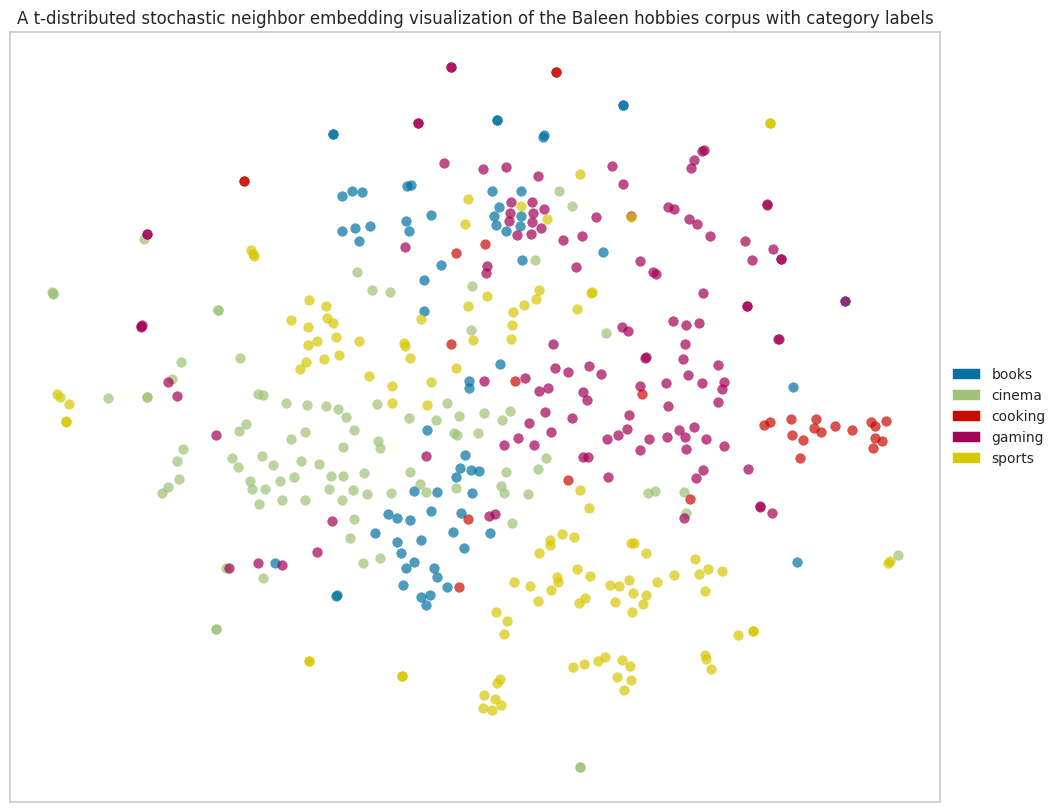

In [52]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(15, 10))
tsne = TSNEVisualizer(
    ax=ax, random_state=42,
    title='A t-distributed stochastic neighbor embedding visualization of the Baleen hobbies corpus with category labels',
)
tsne.fit(docs, labels)
tsne.show()
plt.show()

## Diagnosing Classification Error

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [54]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError

In [55]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    """Transforms sparse to dense"""

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray()

### Classification report heatmaps

In [56]:
encoder = LabelEncoder()

In [57]:
X = corpus.data
y = encoder.fit_transform(corpus.target)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [59]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('dense_transformer', DenseTransformer()),
    ('classifier', GaussianNB())
])

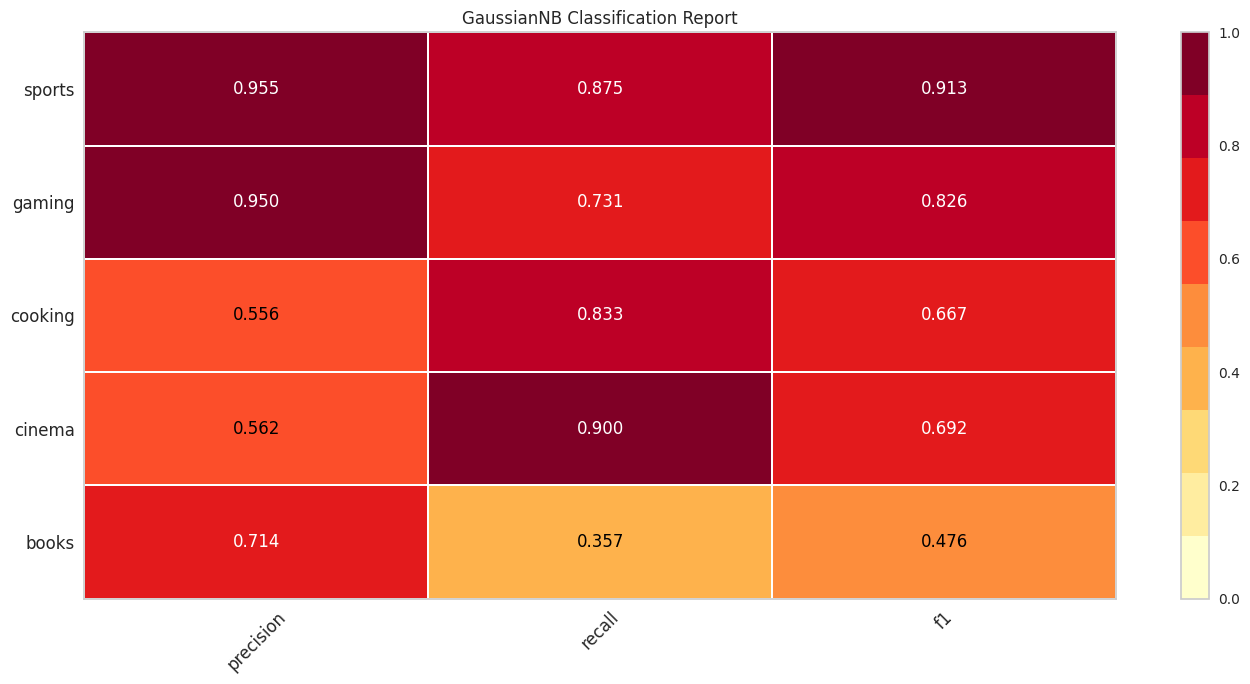

In [60]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
visualizer = ClassificationReport(pipeline, encoder=encoder, ax=ax)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

In [61]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SGDClassifier(random_state=42))
])

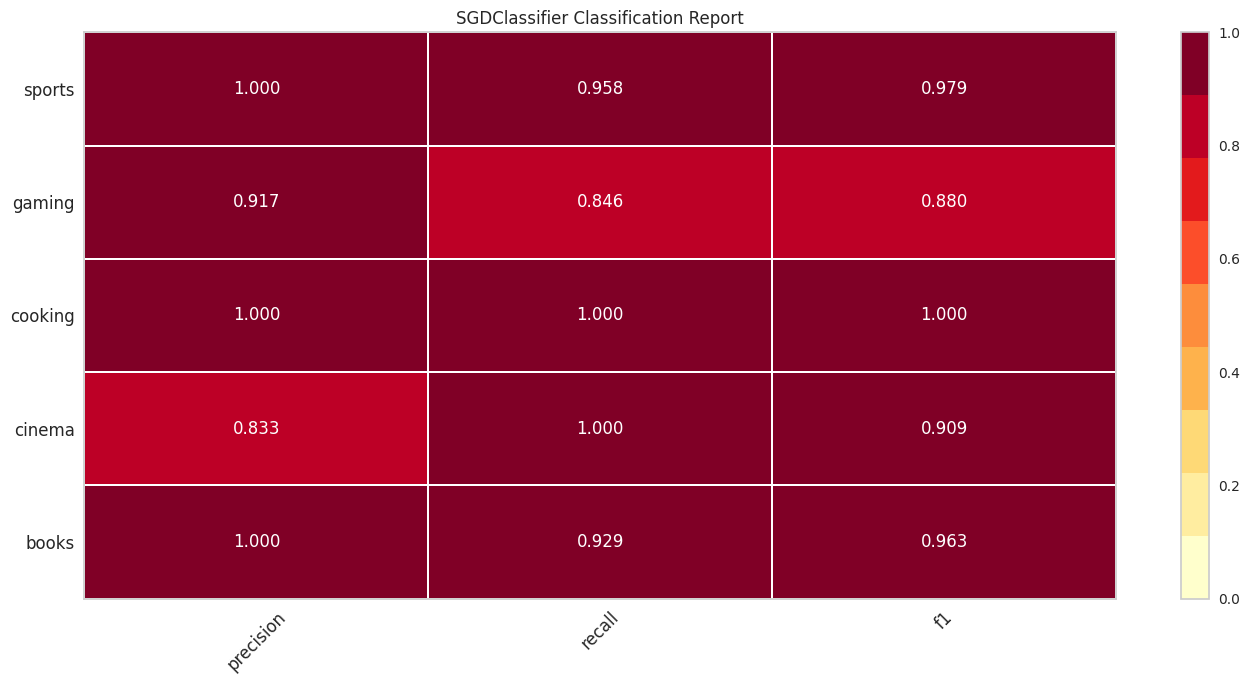

In [62]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
visualizer = ClassificationReport(pipeline, encoder=encoder, ax=ax)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

### Confusion matrices

In [63]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(random_state=42))
])

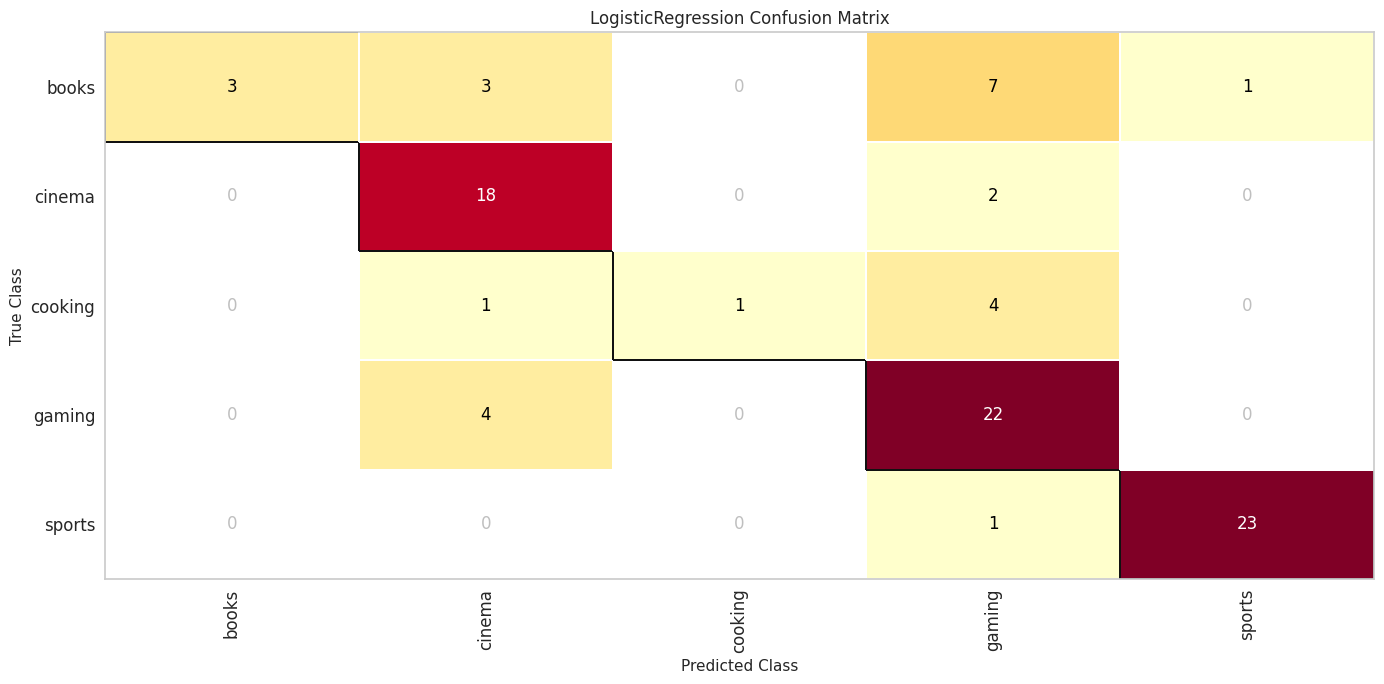

In [64]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
visualizer = ConfusionMatrix(pipeline, encoder=encoder, ax=ax)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

In [65]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

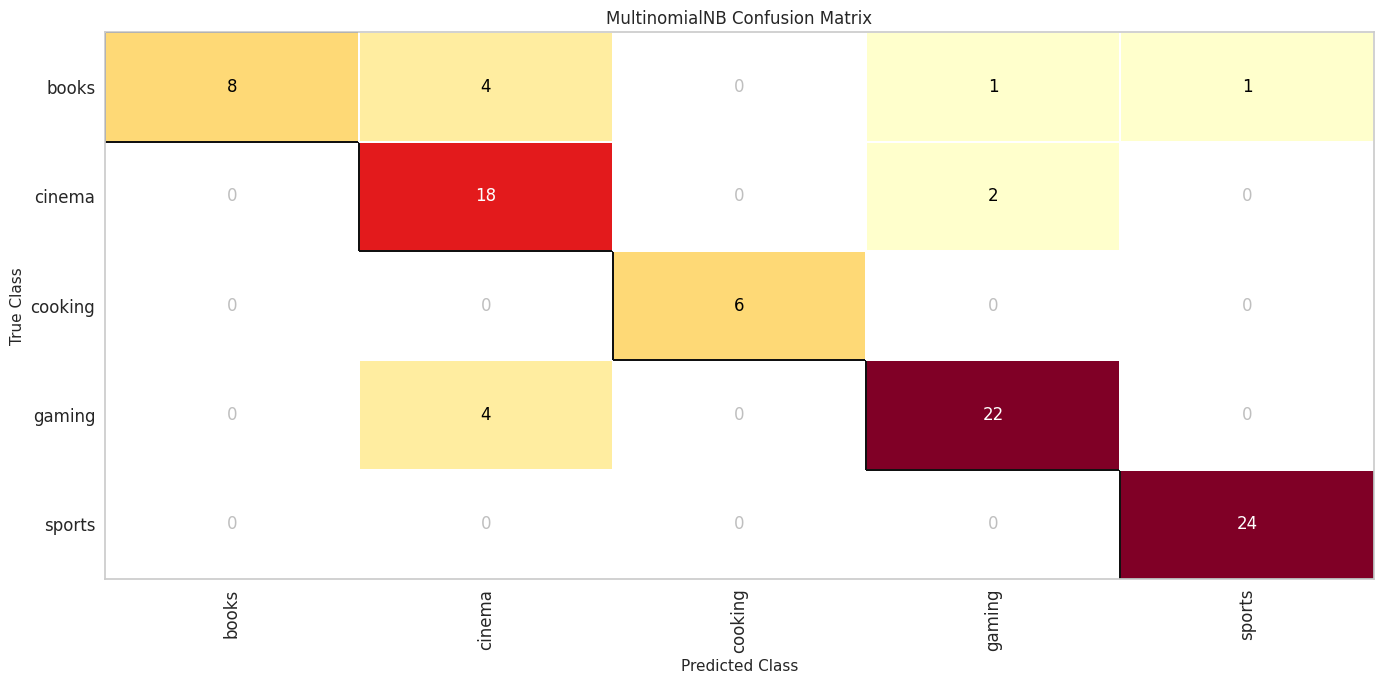

In [66]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
visualizer = ConfusionMatrix(pipeline, encoder=encoder, ax=ax)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

### Class prediction error

In [67]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=42))
])

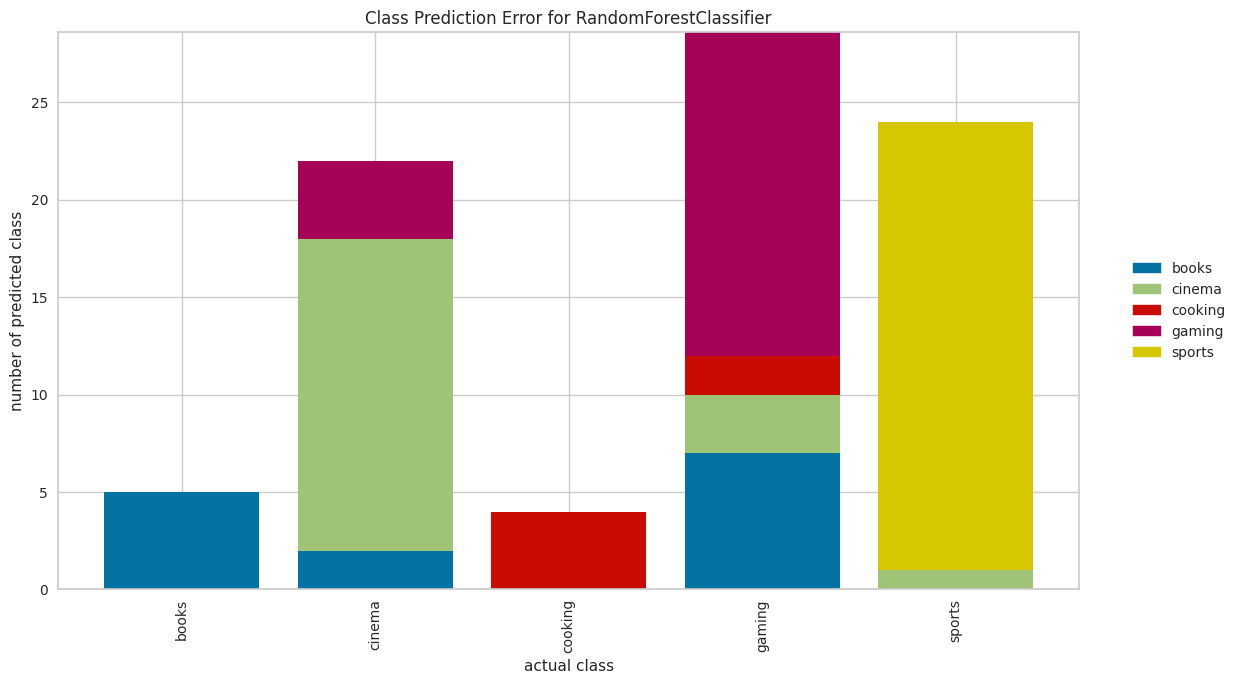

In [68]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
visualizer = ClassPredictionError(pipeline, encoder=encoder, ax=ax)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

# Visual Steering

## Silhouette Scores and Elbow Curves

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [70]:
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [71]:
vectorizer = TfidfVectorizer()
docs = vectorizer.fit_transform(corpus.data)

### Silhouette scores

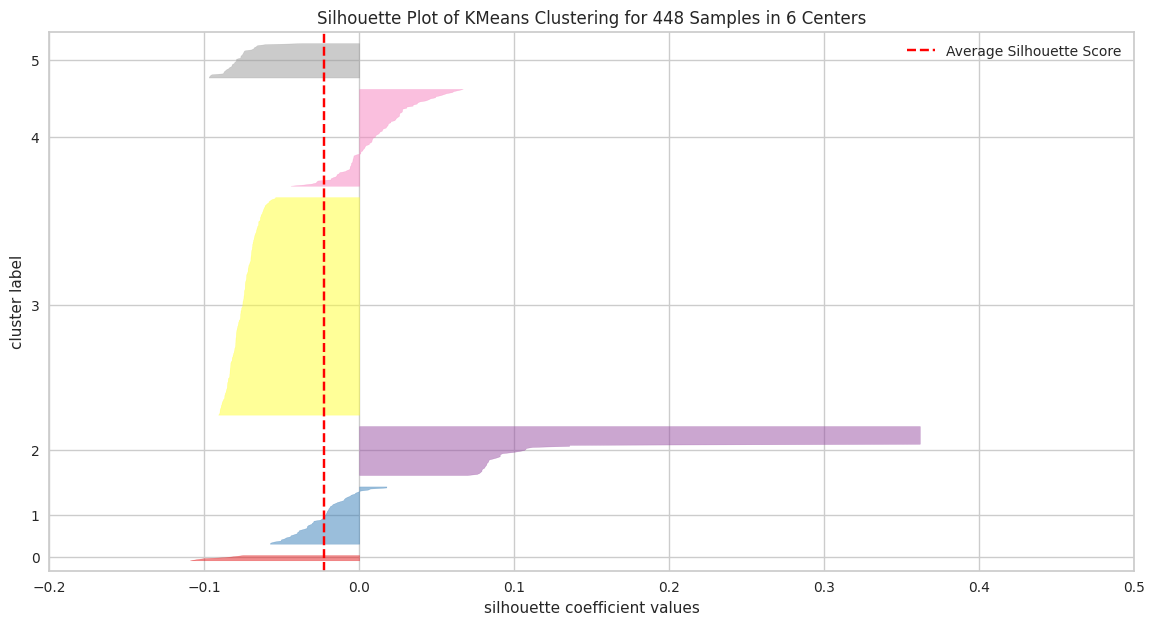

In [72]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
clusterer = KMeans(n_clusters=6, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(clusterer, ax=ax)
visualizer.fit(docs)
visualizer.show()
plt.show()

### Elbow curves

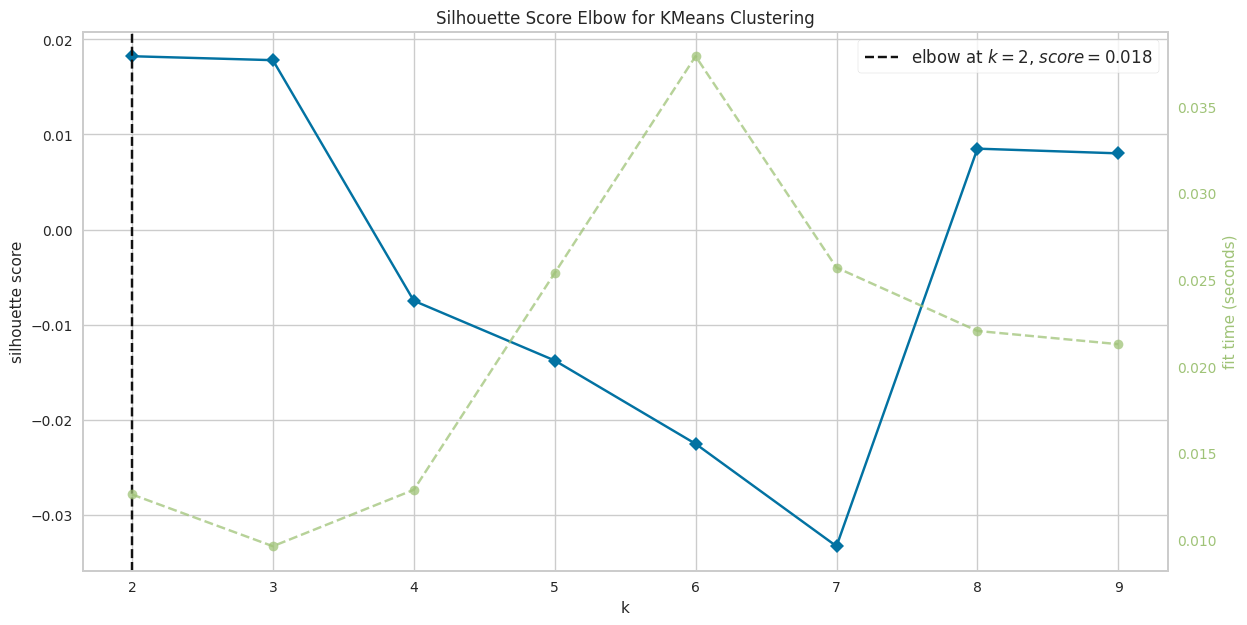

In [73]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
clusterer = KMeans(n_init='auto', random_state=42)
visualizer = KElbowVisualizer(clusterer,
                              ax=ax,
                              k=(2, 10),
                              metric='silhouette')
visualizer.fit(docs)
visualizer.show()
plt.show()

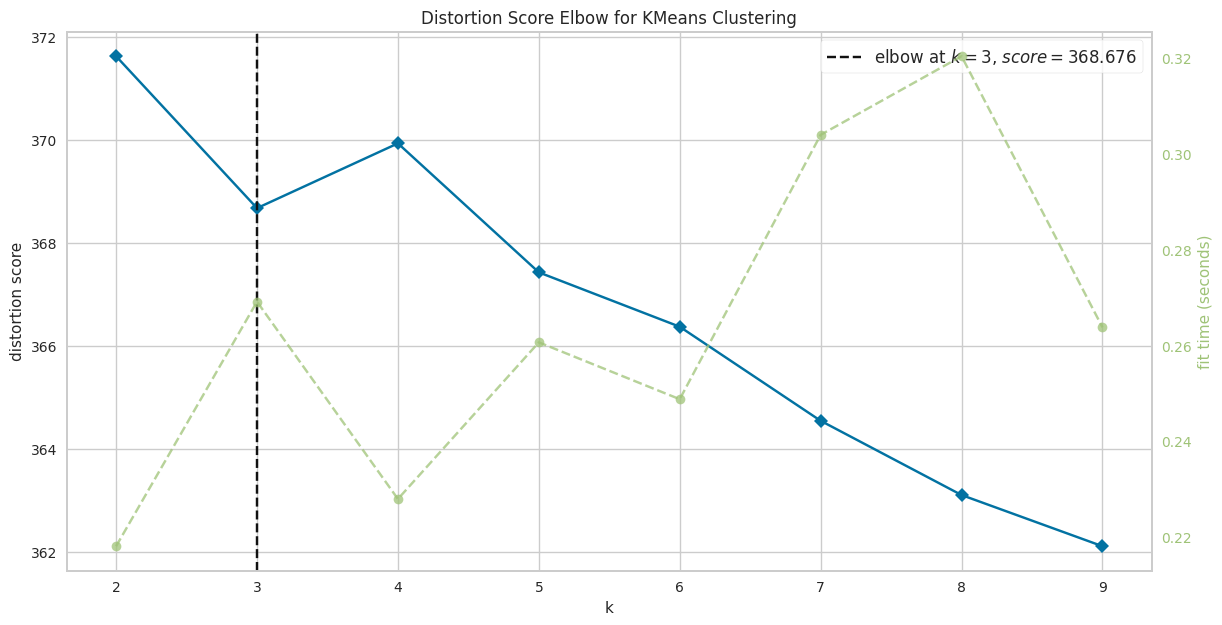

In [74]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
clusterer = KMeans(n_init='auto', random_state=42)
visualizer = KElbowVisualizer(clusterer,
                              ax=ax,
                              k=(2, 10),
                              metric='distortion')
visualizer.fit(docs.toarray())
visualizer.show()
plt.show()

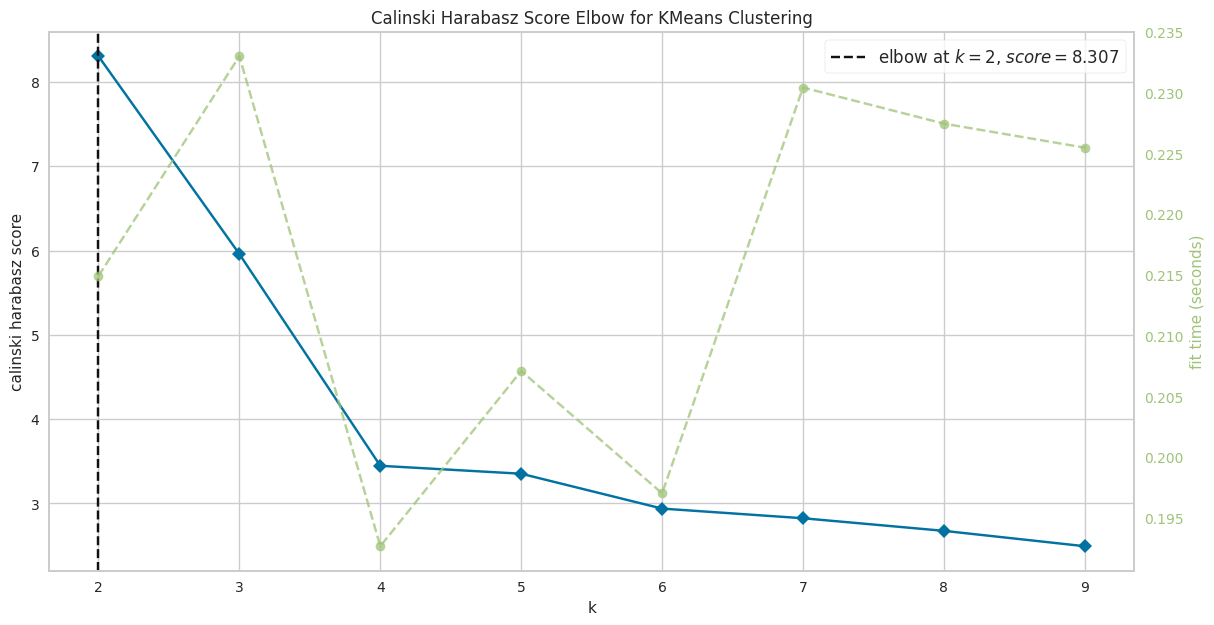

In [75]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(14, 7))
clusterer = KMeans(n_init='auto', random_state=42)
visualizer = KElbowVisualizer(clusterer,
                              ax=ax,
                              k=(2, 10),
                              metric='calinski_harabasz')
visualizer.fit(docs.toarray())
visualizer.show()
plt.show()